<a href="https://colab.research.google.com/github/rudycav/Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np
import math
import tensorflow
import requests
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import sem

In [92]:
symbol = 'ETH'

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' E7KN41UXPEIKWXIK'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = symbol, exchange = 'USD', start_date = '2022-04-01')
crypto_df.head()

,open,high,low,close,volume
Date,,,,,
2022-04-01,3281.51,3481.29,3210.68,3455.21,532169.2392
2022-04-02,3455.20,3532.20,3433.14,3443.77,499893.2900
2022-04-03,3443.77,3580.34,3412.11,3521.91,381581.7683
2022-04-04,3521.90,3547.00,3405.97,3519.50,449984.1586
2022-04-05,3519.50,3555.00,3400.00,3406.99,397782.7437


In [93]:
forecast_days = 30
# Model appears to be effective using data from around 105 days back

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['close']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column.tail()

,open,high,low,close,volume,forecast
Date,,,,,,
2022-07-09,1214.03,1235.40,1204.67,1217.02,5.763372e+05,NaN
2022-07-10,1217.02,1219.95,1153.00,1168.36,1.018039e+06,NaN
2022-07-11,1168.37,1171.29,1091.71,1096.40,1.201652e+06,NaN
2022-07-12,1096.37,1098.26,1033.46,1038.58,1.261350e+06,NaN
2022-07-13,1038.58,1046.46,1035.58,1045.24,4.528506e+04,NaN


In [94]:
def smooth_data(data, alpha):

    return data.ewm(alpha=alpha).mean()

expo_smooth = smooth_data(prediction_column, 0.65)


In [95]:
def independent_dataset(df):
  X = np.array(prediction_column.close)
  X = X[:-forecast_days]

  return X

x_dataset = independent_dataset(expo_smooth)

In [96]:
x_dataset.shape

(74,)

In [97]:
def dependent_dataset(df):
  y = prediction_column.forecast.values
  y = y[:-forecast_days]

  return y

y_dataset = dependent_dataset(expo_smooth)

In [98]:
y_dataset.shape

(74,)

In [99]:
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)

In [100]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51, 1), (23, 1), (51,), (23,))

In [101]:
def regression_model(X_train, y_train, X_test, y_test):
  lin_reg_model = LinearRegression()
  lin_reg_model.fit(X_train, y_train)

  score_acc = lin_reg_model.score(X_test, y_test)
  score_acc = round(score_acc,2)
  score_acc

  return lin_reg_model, score_acc

linear_regression_model, accuracy_score = regression_model(X_train, y_train, X_test, y_test)

In [102]:
print(f'Model accuracy score: {accuracy_score}')

Model accuracy score: 0.83


In [103]:
actual_price = np.array(crypto_df[['close']])[-forecast_days:]
forecast_prediction = linear_regression_model.predict(actual_price)
forecast_prediction

array([600.83129198, 625.63176479, 479.16859515, 495.1476559 ,
       415.59030407, 531.18719693, 530.93589934, 528.86486055,
       463.30218504, 545.21653498, 614.79997198, 629.82583497,
       591.20399453, 586.62864525, 544.63595088, 506.64668714,
       481.34361914, 471.56900931, 477.87744544, 484.15988527,
       550.65842769, 534.62737433, 581.4813773 , 625.60576849,
       605.28532518, 607.86762459, 565.70162154, 503.3451567 ,
       453.24161588, 459.01279509])

In [104]:
def get_future_dates(datetime):
  future_dates = []

  datetime = datetime

  for i in range(forecast_days): 
    datetime += timedelta(days=1)
    future_dates.append(datetime.strftime('%Y-%m-%d'))

  return future_dates

future_dates = get_future_dates(datetime.now())

In [105]:
def datetime_index(forecast_df, crypto_df):

  forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
  forecast_df['Date'] = future_dates
  forecast_df.set_index('Date', inplace=True)
  forecast_df.index = pd.to_datetime(forecast_df.index)
  crypto_df.index = pd.to_datetime(crypto_df.index)

  return forecast_df, crypto_df

forecast_df, crypto_df = datetime_index(future_dates, crypto_df)

In [106]:
print(forecast_df.head())

              forecast
Date                  
2022-07-14  600.831292
2022-07-15  625.631765
2022-07-16  479.168595
2022-07-17  495.147656
2022-07-18  415.590304


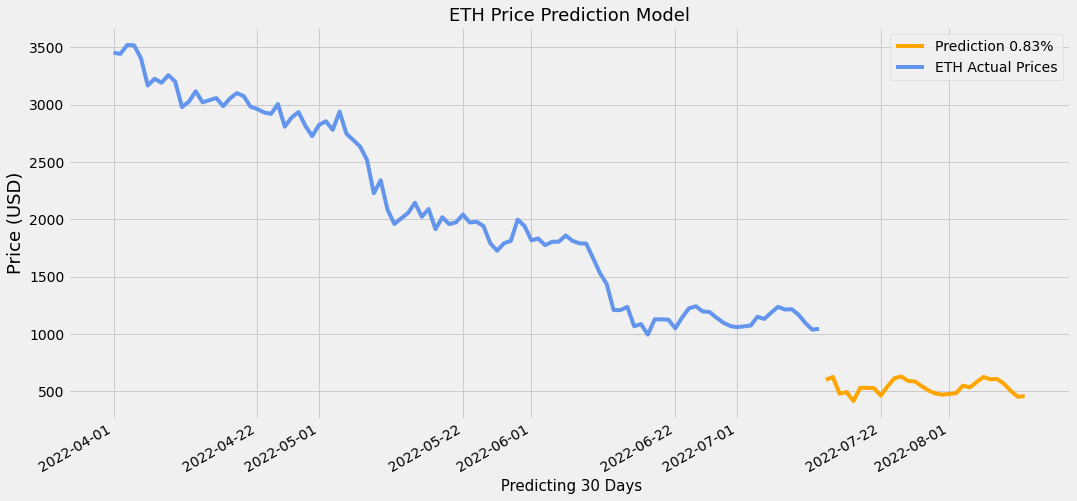

<module 'matplotlib.pylab' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pylab.py'>

In [107]:
import matplotlib.dates as mdates

def plot_model():
  plt.figure(figsize=(16,8))
  plt.plot(forecast_df.forecast, color='orange', label = f'Prediction {accuracy_score}%')
  plt.plot(crypto_df.close, color='cornflowerblue', label = f'{symbol} Actual Prices')
  plt.title(f'{symbol} Price Prediction Model', fontsize=18)
  plt.xlabel(f' Predicting {forecast_days} Days', fontsize=15)
  plt.ylabel('Price (USD)', fontsize=18)
  plt.legend(loc='upper right')
  plt.gcf().autofmt_xdate()

  plt.show()

  return plt

plot_model()